# Zillow Regression Project
### Anna Vu (June 2021)

### Executive Summary: 
Square footage, number of bathrooms, number of bedrooms, and property age were features used to make a model that predicts home values in California. It performs better than the baseline with an R^2 value of .42, and a lower RMSE.

<br>

The goal of this project is to create a regression model that predicts home values in Los Angeles County, Orange County, and Ventura County as accurately as possible. 

We were asked to work with single unit properties in this area that were sold during the months of May-Aug 2017.

### Hypothesis

1.) The larger the square footage, the higher the property value

2.) The more bedrooms a house has, the higher its property value will be

3.) The more bathrooms a house has, the higher its property value will be

4.) The older a house is, the less it will be worth.

5.) Value is dependent on property location

In [1]:
#import stuff we will need
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

#import functions from my .py files
from acquire import get_zillow_data
from prep import remove_outlier, clean_zillow, train_validate_test, get_object_cols, get_numeric_X_cols, min_max_scale, clean_zillow_taxes, remove_outlier_tax
from explore import plot_variable_pairs, plot_pairplot, correlation_exploration, get_zillow_heatmap

<br>

<br>

## Acquire

In [2]:
#use get_zillow_data() to return Zillow data into a pandas dataframe called 'df'
df = get_zillow_data()

In [3]:
#make sure it works. We can see it has 38,622 rows and 62 columns.
df

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,NaN,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,NaN,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,NaN,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38617,14453399,356752,NaN,NaN,NaN,3.0,5.0,NaN,NaN,3.0,...,852813.0,2016.0,496831.0,11662.88,NaN,NaN,6.059032e+13,72840,0.062928,2017-08-31
38618,12019061,2108804,1.0,NaN,NaN,2.0,1.0,NaN,9.0,2.0,...,492395.0,2016.0,366200.0,6023.37,NaN,NaN,6.037701e+13,72841,0.000231,2017-08-31
38619,11570288,108621,1.0,NaN,NaN,2.0,2.0,NaN,7.0,2.0,...,600608.0,2016.0,446625.0,7255.87,NaN,NaN,6.037264e+13,72842,-0.003178,2017-08-31
38620,11128688,2001476,1.0,NaN,NaN,3.0,5.0,NaN,7.0,3.0,...,1120000.0,2016.0,728000.0,13663.03,NaN,NaN,6.037108e+13,72843,0.024946,2017-08-31


Takeaways: 
 - Lots of columns and null values
 - Probably not a good idea to try and fill most of these null values in, they may mess up our model.
 - We won't need most of these columns

<br>

## Prepare

In [4]:
#clean_zillow will only select my preferred relevant columns, rename columns, drop duplicates, and drop/fill in nulls
#we now are down to 38,475 rows and 6 columns.
df = clean_zillow(df)
df.shape

(38475, 6)

In [5]:
#seeing data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38475 entries, 14634203 to 10713993
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sqft       38475 non-null  float64
 1   baths      38475 non-null  float64
 2   beds       38475 non-null  float64
 3   tax_value  38475 non-null  float64
 4   fips       38475 non-null  float64
 5   age        38475 non-null  float64
dtypes: float64(6)
memory usage: 2.1 MB


In [6]:
#let's remove rows with outliers (values more than three standard deviations away from the mean)
#down to 37,927 rows and 6 columns
df = remove_outlier(df)
df.shape

(37927, 6)

In [7]:
#summary statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sqft,37927.0,1719.082079,817.108495,240.0,1169.0,1512.0,2050.0,11020.0
baths,37927.0,2.243929,0.879170,0.0,2.0,2.0,3.0,10.0
beds,37927.0,2.999815,0.998060,0.0,2.0,3.0,4.0,11.0
tax_value,37927.0,443651.087879,356733.252926,1000.0,206900.0,358930.0,563463.0,2377148.0
fips,37927.0,6049.965275,21.484878,6037.0,6037.0,6037.0,6059.0,6111.0
age,37927.0,47.567327,22.962371,0.0,30.0,46.0,63.0,139.0


In [8]:
#assuring there are no null values
df.isna().sum()

sqft         0
baths        0
beds         0
tax_value    0
fips         0
age          0
dtype: int64

In [9]:
#let's split our data using my train_validate_test function, and check our train, validate, and test shapes. Our target is tax_value.
target = 'tax_value'
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, target)
train.shape, validate.shape, test.shape

((21238, 6), (9103, 6), (7586, 6))

In [10]:
#let's scale our data using the min_max_scale function. Not scaling the target. 
#since I used z-score to weed out outliers, this should work fine.
obj_cols = get_object_cols(df)
num_cols = get_numeric_X_cols(X_train, obj_cols)
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, num_cols)

Takeaways:
 - The set is a lot smaller to work with after only taking columns I found relevant, and dropped all rows with nulls and/or outliers.
 - All columns are numeric

<br>

## Explore

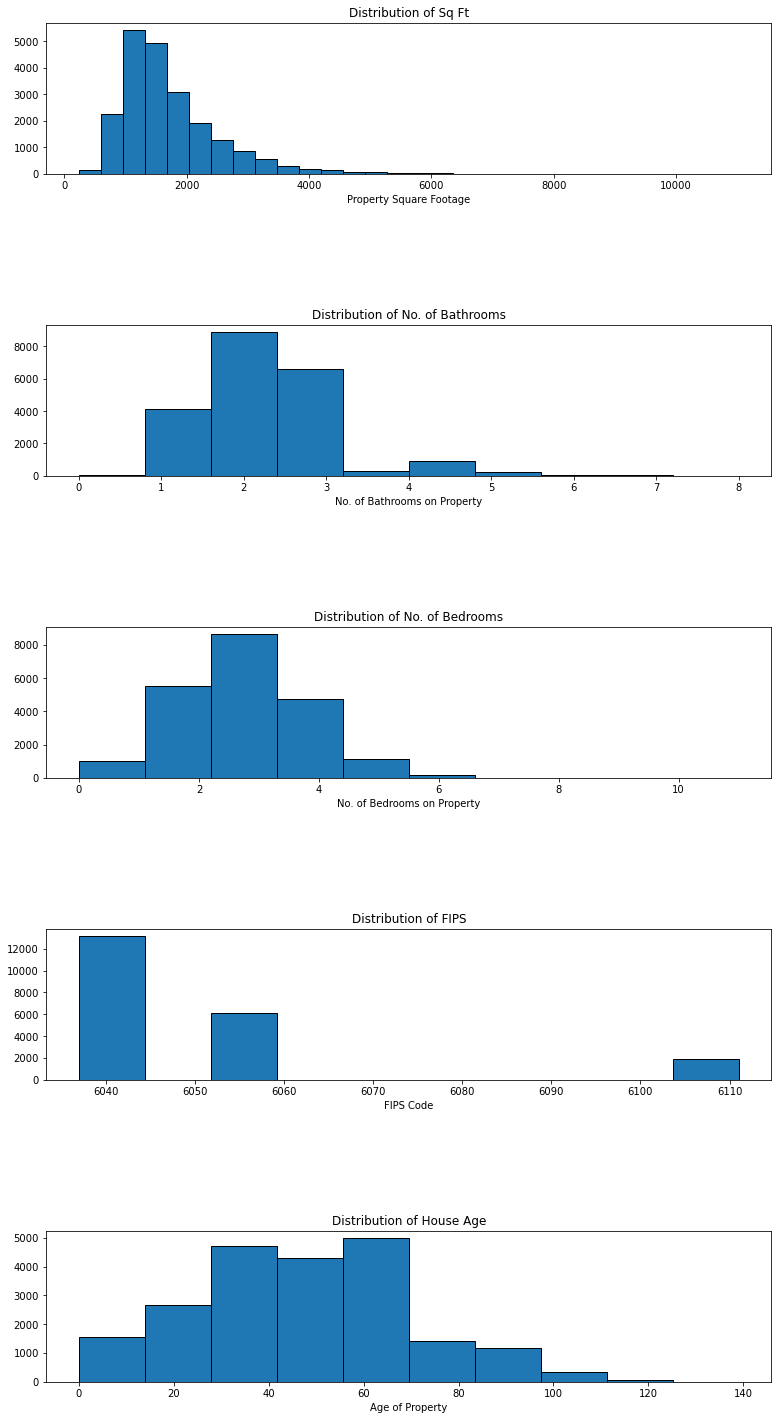

In [11]:
#checking distributions of our selected features/univariate exploration
plt.figure(figsize=(13,25))
plt.subplot(5,1,1, xlabel = 'Property Square Footage', title='Distribution of Sq Ft')
plt.hist(data=train, x='sqft', bins = 30,ec='black')

plt.subplot(5,1,2, xlabel = 'No. of Bathrooms on Property',title='Distribution of No. of Bathrooms')
plt.hist(data=train, x='baths', ec='black')

plt.subplot(5,1,3, xlabel = 'No. of Bedrooms on Property', title='Distribution of No. of Bedrooms')
plt.hist(data=train, x='beds',ec='black')

plt.subplot(5,1,4, xlabel = 'FIPS Code',title='Distribution of FIPS')
plt.hist(data=train, x='fips',ec='black')

plt.subplot(5,1,5, xlabel = 'Age of Property',title='Distribution of House Age')
plt.hist(data=train, x='age',ec='black')

plt.subplots_adjust(hspace=1)
plt.show()

In [12]:
#our columns of the dataframe
cols = ['sqft', 'baths','beds', 'fips', 'age','tax_value']

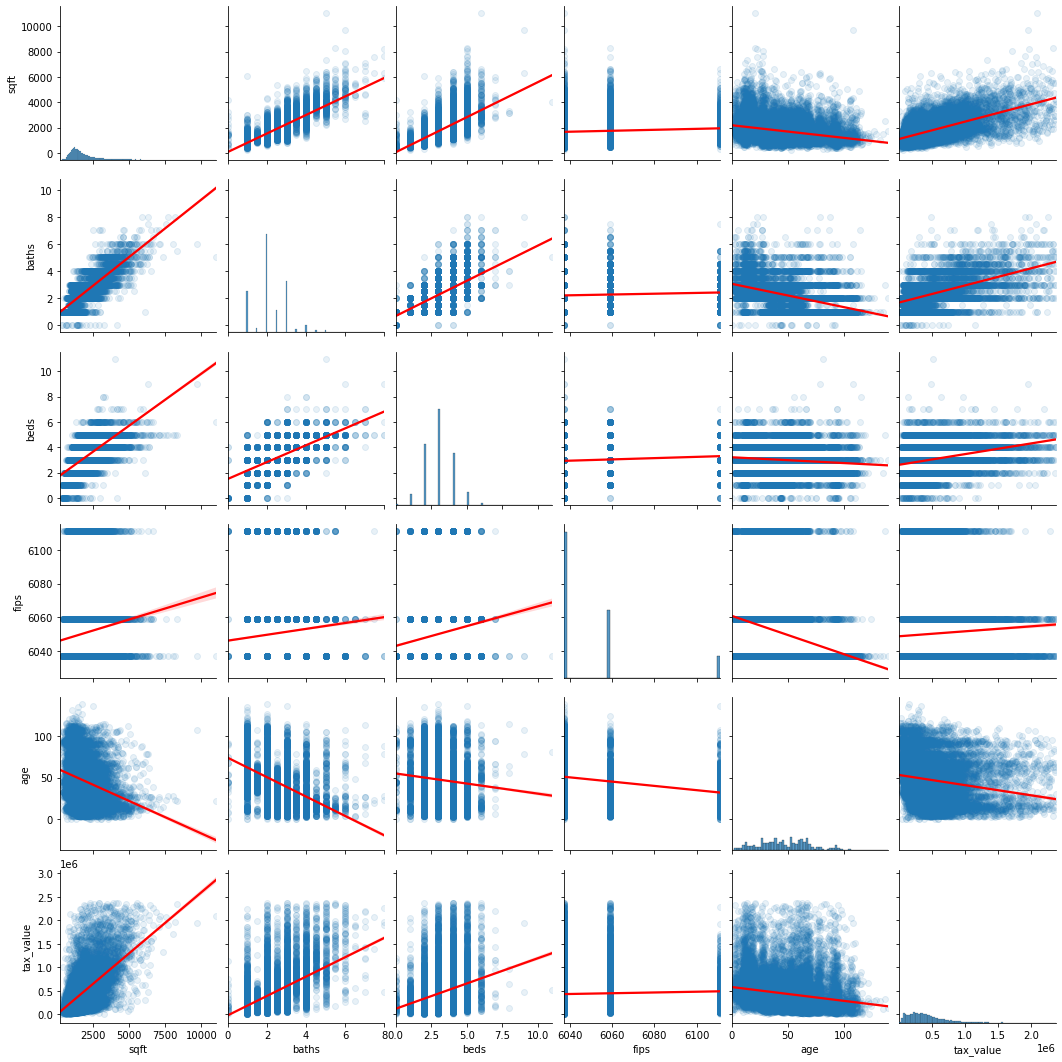

In [13]:
#pairplots 
plot_variable_pairs(train, cols)

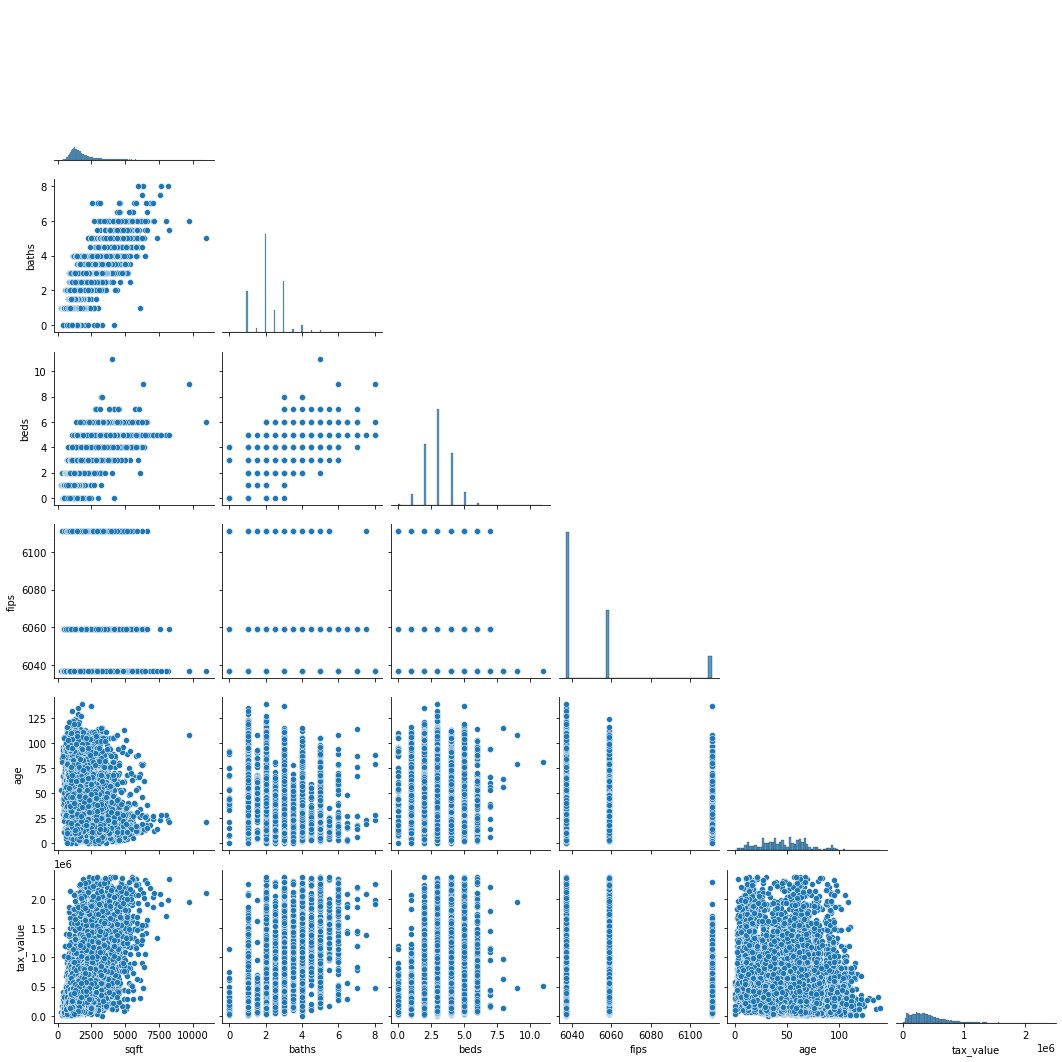

In [14]:
#scatter plots and histograms
plot_pairplot(train, cols, hue=None)

<AxesSubplot:title={'center':'Feautures Correlating with Value'}>

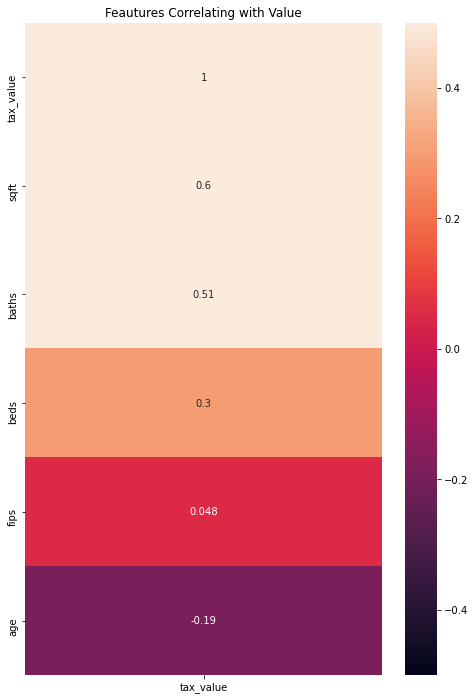

In [15]:
#heatmap with correlation of feature to tax_value
get_zillow_heatmap(train)

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.6


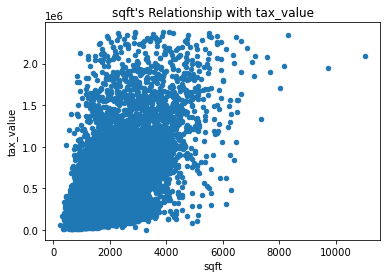

In [16]:
#sqft and tax_value
correlation_exploration(train, 'sqft', 'tax_value')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.51


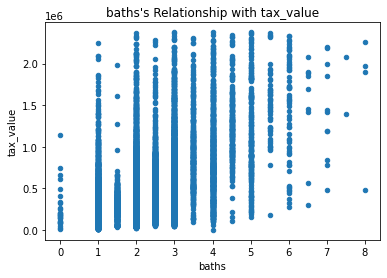

In [17]:
#baths and tax_value
correlation_exploration(train, 'baths', 'tax_value')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.3


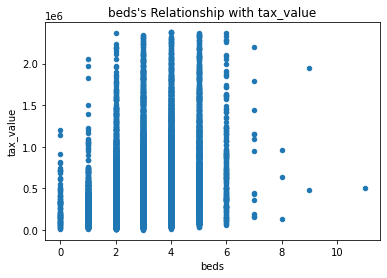

In [18]:
#beds and tax_value
correlation_exploration(train, 'beds', 'tax_value')

The p-value is: 1.5961658280325072e-12. There is 0.0% chance that we see these results by chance.
r = 0.05


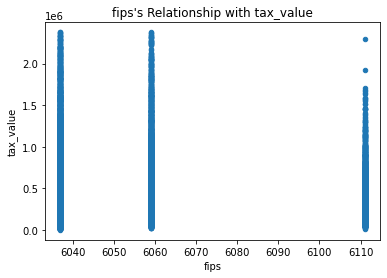

In [19]:
#FIPS and tax_value
correlation_exploration(train, 'fips', 'tax_value')

The p-value is: 8.030729987793436e-172. There is 0.0% chance that we see these results by chance.
r = -0.19


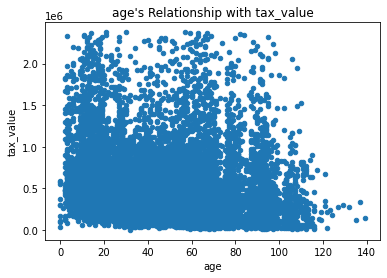

In [20]:
#age and tax_value
correlation_exploration(train, 'age', 'tax_value')

The p-value is: 0.0. There is 0.0% chance that we see these results by chance.
r = 0.59


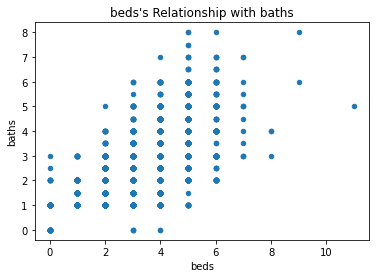

In [21]:
#Correlation between beds and baths, seems that they have a positive correlation with each other.
correlation_exploration(train, 'beds', 'baths')

The p-value is: 9.225667767564335e-48. There is 0.0% chance that we see these results by chance.
r = 0.1


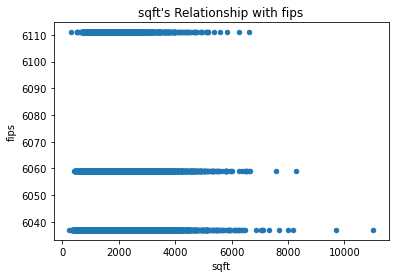

In [22]:
#Properties in Los Angeles (FIPS 6037) have a large range in square footage. Ventura (FIPS 6111) has the smallest range. 
correlation_exploration(train, 'sqft', 'fips')

In [23]:
# t test for square footage and value, I used 1800 sqft because it is roughly the mean area of all selected properties.
# The results suggest they are related to each other.
null_hypothesis = "Values of houses with 1800 sq ft or more, and houses with less square footage independent to value of home"
alternative_hypothesis = "Values of houses with 1800 sq ft or more, and houses with less square footage not independent to value of home"
a = 0.05 #a for alpha 

bigger_houses = train[train.sqft>=1800]
smaller_houses = train[train.sqft<1800]
t, p = stats.ttest_ind(bigger_houses.tax_value, smaller_houses.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Values of houses with 1800 sq ft or more, and houses with less square footage independent to value of home
There is evidence to suggest: Values of houses with 1800 sq ft or more, and houses with less square footage not independent to value of home


In [24]:
# a t test for bedrooms and value, I picked 3 because it is roughly the mean number of bedrooms for all selected houses
# The results suggest they are related to each other.
null_hypothesis = "Houses with 3 bedrooms or more and houses with less than 3 bedrooms are independent to value of home"
alternative_hypothesis = "Houses with 3 bedrooms or more and houses with less than 3 bedrooms are related to value of home"
a = 0.05 #a for alpha 

three_or_more_beds = train[train.beds>=3]
less_than_three_beds = train[train.beds<3]
t, p = stats.ttest_ind(three_or_more_beds.tax_value, less_than_three_beds.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Houses with 3 bedrooms or more and houses with less than 3 bedrooms are independent to value of home
There is evidence to suggest: Houses with 3 bedrooms or more and houses with less than 3 bedrooms are related to value of home


In [25]:
# a t test for bathrooms and value, I picked 3 because the mean was over 2. 
# The results suggest they are related to each other.
null_hypothesis = "Houses with 3 bathrooms or more and houses with less than 3 bathrooms are independent to value of home"
alternative_hypothesis = "Houses with 3 bathrooms or more and houses with less than 3 bathrooms are related to value of home"
a = 0.05 #a for alpha 

three_or_more_baths = train[train.baths>=3]
less_than_three_baths = train[train.baths<3]
t, p = stats.ttest_ind(three_or_more_baths.tax_value, less_than_three_baths.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Reject null hypothesis that: Houses with 3 bathrooms or more and houses with less than 3 bathrooms are independent to value of home
There is evidence to suggest: Houses with 3 bathrooms or more and houses with less than 3 bathrooms are related to value of home


In [26]:
# a t test for age, I picked 10 because I would say any house made within the decade is considered fairly new. 
# The results suggest there is not much of a difference in value of homes depending on age. 
null_hypothesis = "House age is independent to value of home"
alternative_hypothesis = "A house being 10 years or older, or less than 10 years, have an affect on value"
a = 0.05 #a for alpha 

old_houses = train[train.age>=10]
new_houses = train[train.baths<10]
t, p = stats.ttest_ind(old_houses.tax_value, new_houses.tax_value)

if p < a:
    print(f'Reject null hypothesis that: {null_hypothesis}')
    print (f'There is evidence to suggest: {alternative_hypothesis}')
else:
    print(f'Fail to reject null hypothesis that: {null_hypothesis} There is not sufficient evidence to reject it.')

Fail to reject null hypothesis that: House age is independent to value of home There is not sufficient evidence to reject it.


Takeaways:
 - Most distributions are normal or slightly skewed to the right, except for FIPS which most of these properties are in Los Angeles County
 - Square footage has a positive correlation with tax value
 - No. of bedrooms and bathrooms have a positive relationship with tax value
 - No. of bedrooms and bathrooms have a positive relationship with each other
 - Square footage tends to be bigger for properties with more bedrooms or bathrooms (as expected, sqft, number of beds/baths are all related)
 - Age has a negative correlation with tax value, but according to the t test, it may not have a super drastic affect.
 - Seems that properties in Los Angeles County tend to have more square footage and value than Orange County and Ventura County

<br>

### Modeling

I selected features that I found to be relevant, and didn't have to fill too many nulls for...but maybe a late use of feature engineering can tell us which ones I should use for my model.

In [27]:
#tells us which features we should keep from the columns I pulled. It says I should use sqft, baths, beds, and age in my model
cols = list(X_train_scaled.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

selected_features_BE = cols
print(selected_features_BE)

['sqft', 'baths', 'beds', 'age']


I should not use fips in my model

In [28]:
#using RFE to test for features to use. I set a range from 1-7 to see if it would use some or all of the features I pulled.
#It ends up telling us we should use four of the features to have the best model score.
number_of_features_list=np.arange(1,7)
high_score=0

#Variable to store the optimum features
number_of_features=0           
score_list =[]

for n in range(len(number_of_features_list)):
    model = LinearRegression()
    rfe = RFE(model,number_of_features_list[n])
    X_train_rfe = rfe.fit_transform(X_train_scaled,y_train)
    X_test_rfe = rfe.transform(X_test_scaled)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        number_of_features = number_of_features_list[n]

print("Optimum number of features: %d" %number_of_features)
print("Score with %d features: %f" % (number_of_features, high_score))

Optimum number of features: 4
Score with 4 features: 0.376712


In [29]:
#let's find out which four it wants us to use
#Sqft, baths, beds, and age.
cols = list(X_train.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 4)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  

#Fitting the data to model
model.fit(X_rfe,y_train)
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index

print(selected_features_rfe)

Index(['sqft', 'baths', 'beds', 'age'], dtype='object')


We should really not use fips in our model. We should use sqft, baths, beds, and age according to both methods of feature selection.
Here are our selected features:

In [30]:
selected_features = ['sqft', 'baths', 'beds', 'age']

<br>
<br>

Let's make a baseline model

In [31]:
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#tax_value mean
tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

#tax_value_median
tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

#RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print('             BASELINE')
print('----------------------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
print('----------------------------------')

#RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
print('----------------------------------')
r2_baseline = r2_score(y_validate.tax_value, y_validate.tax_value_pred_mean)
print(f'The r^2 score for baseline is {r2_baseline}')

             BASELINE
----------------------------------
RMSE using Mean
Train/In-Sample:  357185.61 
Validate/Out-of-Sample:  359454.06
----------------------------------
RMSE using Median
Train/In-Sample:  367038.13 
Validate/Out-of-Sample:  369101.89
----------------------------------
The r^2 score for baseline is -3.072081049992903e-06


In [32]:
#Our first model: LinearRegression
#create model object
lm = LinearRegression(normalize=True)

#fit the model to our training data, specify column since it is a dataframe
lm.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

#predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression:\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lm = r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm)
print(f'The r^2 value for linear regression is {round(r2_score_lm,3)}')

RMSE for OLS using LinearRegression:
Training/In-Sample:  280731.1959936711 
Validation/Out-of-Sample:  279672.6834686621
The r^2 value for linear regression is 0.395


In [33]:
#LassoLars 
#create model object
lars = LassoLars(alpha=1.0)

#fit the model to our training data, specify column since it is a dataframe
lars.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

#predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for OLS using Lasso+Lars\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lars = r2_score(y_validate.tax_value, y_validate.tax_value_pred_lars)
print(f'The r^2 value for LassoLars regression is {round(r2_score_lars,3)}')

RMSE for OLS using Lasso+Lars
Training/In-Sample:  280731.6019596922 
Validation/Out-of-Sample:  279675.51693743526
The r^2 value for LassoLars regression is 0.395


In [34]:
#TweedieRegressor, I found using 0 power and 0 for alpha yielded the best results...
#create model object
glm = TweedieRegressor(power =0, alpha=0.00)

#fit the model to our training data, specify column since it is a dataframe
glm.fit(X_train_scaled[selected_features],y_train.tax_value)

#predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train_scaled[selected_features])

#evaluate the RMSE for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

#predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate_scaled[selected_features])

#evaluate the RMSE for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for OLS using TweedieRegressor\nTraining/In-Sample: ",rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_glm = r2_score(y_validate.tax_value, y_validate.tax_value_pred_glm)
print(f'The r^2 value for TweedieRegressor is {round(r2_score_glm,3)}')

RMSE for OLS using TweedieRegressor
Training/In-Sample:  280731.1959936711 
Validation/Out-of-Sample:  279672.68346835295
The r^2 value for TweedieRegressor is 0.395


In [35]:
#making polynomial features to get a new set of features, I found that degree=3 yielded the best results.
pf = PolynomialFeatures(degree=3)

#fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled[selected_features])

#transform X_validate_scaled, and X_test_scaled
X_validate_degree3 = pf.transform(X_validate_scaled[selected_features])
X_test_degree3 = pf.transform(X_test_scaled[selected_features])

#okay let's do linear regression again with our new degree
lm3 = LinearRegression(normalize=True)

#fit the model using scaled X_train, once again specify y_train column
lm3.fit(X_train_degree3, y_train.tax_value)

#predict train
y_train['tax_value_pred_lm3'] = lm3.predict(X_train_degree3)

#evaluate rmse for train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm3)**(1/2)

#predict validate
y_validate['tax_value_pred_lm3'] = lm3.predict(X_validate_degree3)

#evaluate rmse for validate
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
r2_score_lm3 = round(r2_score(y_validate.tax_value, y_validate.tax_value_pred_lm3),2)
print(f'The r^2 value for TweedieRegressor is {round(r2_score_lm3,3)}')

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  276310.6526820274 
Validation/Out-of-Sample:  274076.30740976887
The r^2 value for TweedieRegressor is 0.42


<br>

This graph is going to visualize our residuals (the errors). The closer a dot is to the line means the closer the prediction was to the actual value (a good thing!)

Text(0.5, 1.0, 'Residuals')

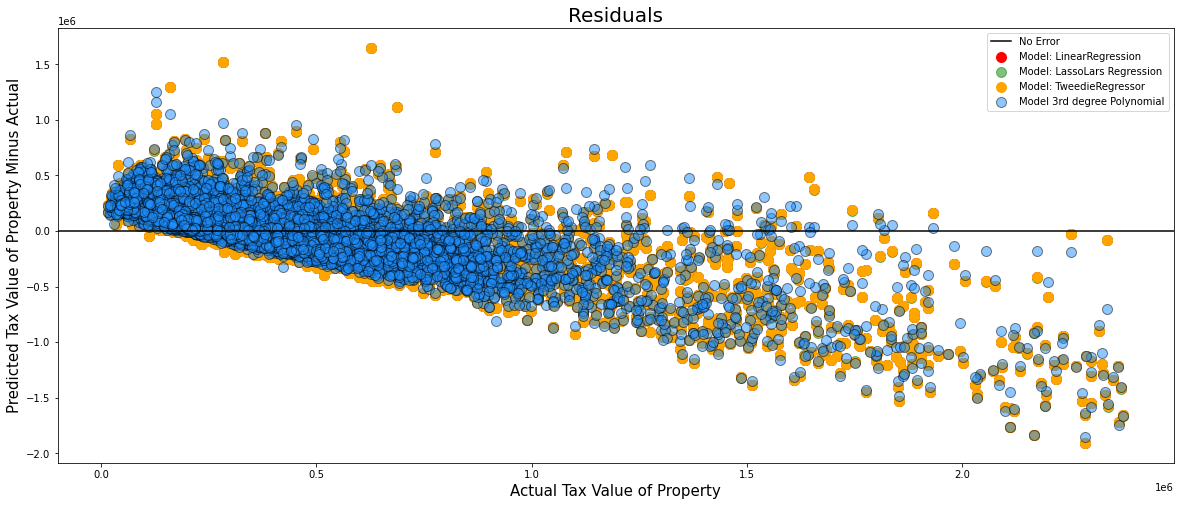

In [36]:
plt.figure(figsize=(20,8))
plt.axhline(label="No Error", color="black")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm-y_validate.tax_value, 
            alpha=1, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lars-y_validate.tax_value, 
            alpha=.5, color="green", s=100, label="Model: LassoLars Regression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm-y_validate.tax_value, 
            alpha=1, color="orange", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm3-y_validate.tax_value, 
            alpha=.5, color="dodgerblue", s=100, edgecolors='black', label="Model 3rd degree Polynomial")
plt.legend()

plt.xlabel("Actual Tax Value of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Tax Value of Property Minus Actual", fontdict={'fontsize':15})
plt.title("Residuals", fontdict={'fontsize': 20})

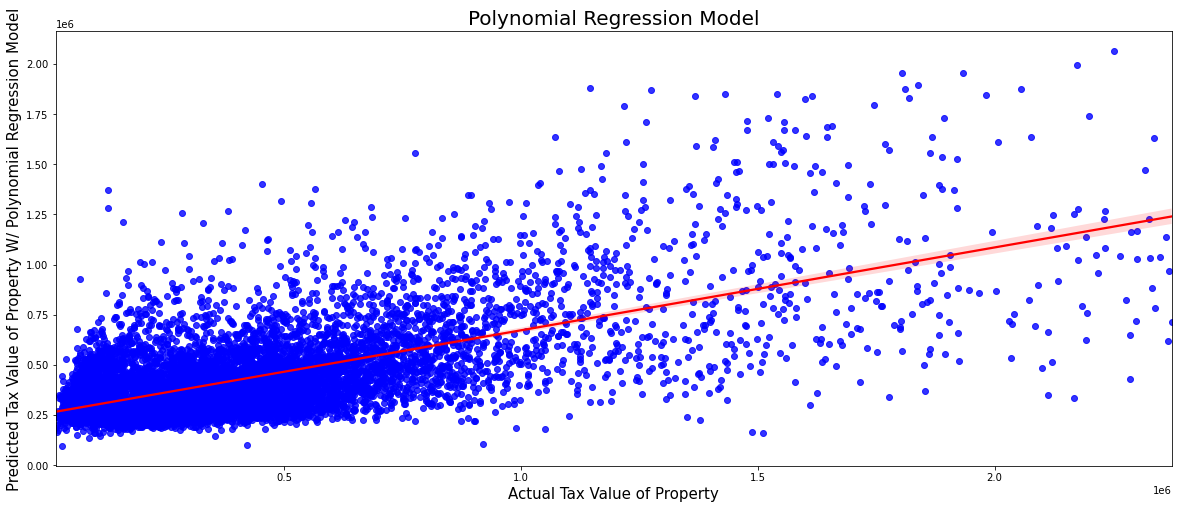

In [37]:
#looks like 3rd degree polynomial did the best, let's visualize that
plt.figure(figsize=(20,8))

sns.regplot(data=y_test, x=y_validate.tax_value, y=y_validate.tax_value_pred_lm3, 
            scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.xlabel("Actual Tax Value of Property", fontdict={'fontsize':15})
plt.ylabel("Predicted Tax Value of Property W/ Polynomial Regression Model", fontdict={'fontsize':15})
plt.title("Polynomial Regression Model", fontdict={'fontsize': 20})

plt.show()

## Test

In [38]:

#turning it into a dataframe
y_test = pd.DataFrame(y_test)

# predicting on our test model
y_test['tax_value_pred_lm3'] = lm3.predict(X_test_degree3)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_lm3)**(1/2)
print('             ')
print('             Our Test Model')
print('----------------------------------')
print('----------------------------------')
print("RMSE for OLS Model using Polynomial (3 degrees)\nOut-of-Sample Performance: ", rmse_test)
r2_test_score_lm3 = r2_score(y_test.tax_value, y_test.tax_value_pred_lm3)
print(f'Polynomial Regression (3 degrees) has an R^2 value of {round(r2_test_score_lm3,3)}')

             
             Our Test Model
----------------------------------
----------------------------------
RMSE for OLS Model using Polynomial (3 degrees)
Out-of-Sample Performance:  272168.26510146545
Polynomial Regression (3 degrees) has an R^2 value of 0.403


<br>

<br>

Our test model (Polynomial regression, 3 degrees) performs better than the baseline. It has a lower RMSE, lower variance between test/validate, and has a higher r^2 value, so it can better explain the variances between predicted and actual home values.

Takeaways:
   - Square footage was the best feature for predicting home value, followed up by bathrooms and bedrooms.
   - Age may have had a little factor, so it was accepted to use to better our model, but there may be other features we could look into next time.
   - Location still may have a factor in value, but we would need data that is more normally distributed. Most of the properties were in Los Angeles County. 

# Tax Rates For Each County

In [39]:
#Now we need to calculate tax rate for each county, an approximate actually.
#I'm going to rebring in the original Zillow dataset.
df = get_zillow_data()
df

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate
0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,289445.0,2016.0,213516.0,3490.16,NaN,NaN,6.059001e+13,625,-0.061973,2017-08-04
1,11721753,616260,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,205123.0,2016.0,163175.0,2627.48,NaN,NaN,6.037220e+13,1018,0.017785,2017-07-21
2,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
3,11637029,2554497,1.0,NaN,NaN,2.0,3.0,NaN,9.0,2.0,...,810694.0,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28
4,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38617,14453399,356752,NaN,NaN,NaN,3.0,5.0,NaN,NaN,3.0,...,852813.0,2016.0,496831.0,11662.88,NaN,NaN,6.059032e+13,72840,0.062928,2017-08-31
38618,12019061,2108804,1.0,NaN,NaN,2.0,1.0,NaN,9.0,2.0,...,492395.0,2016.0,366200.0,6023.37,NaN,NaN,6.037701e+13,72841,0.000231,2017-08-31
38619,11570288,108621,1.0,NaN,NaN,2.0,2.0,NaN,7.0,2.0,...,600608.0,2016.0,446625.0,7255.87,NaN,NaN,6.037264e+13,72842,-0.003178,2017-08-31
38620,11128688,2001476,1.0,NaN,NaN,3.0,5.0,NaN,7.0,3.0,...,1120000.0,2016.0,728000.0,13663.03,NaN,NaN,6.037108e+13,72843,0.024946,2017-08-31


In [40]:
#Made a new clean function for taxes, I also included tax_amount to calculate tax_rate. 
# tax_rate = tax_amount / tax_value 
new_tax = clean_zillow_taxes(df)
new_tax

,sqft,baths,beds,tax_value,fips,tax_amount,age,tax_rate
parcel_id,,,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,3490.16,43.0,0.012058
11721753,1316.0,2.0,3.0,205123.0,6037.0,2627.48,94.0,0.012809
11289917,1458.0,2.0,3.0,136104.0,6037.0,2319.90,47.0,0.017045
11637029,1766.0,2.0,3.0,810694.0,6037.0,9407.01,37.0,0.011604
11705026,1421.0,1.0,2.0,35606.0,6037.0,543.69,106.0,0.015270
...,...,...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,11662.88,15.0,0.013676
12019061,769.0,2.0,1.0,492395.0,6037.0,6023.37,53.0,0.012233
11570288,1212.0,2.0,2.0,600608.0,6037.0,7255.87,48.0,0.012081


In [41]:
#Now we're going to remove outliers, just in case anything is a bit extreme. 
new_tax = remove_outlier_tax(new_tax)

In [42]:
#going to create a new column called county, and it's going to give us the county name based off the FIPS number. 
#yes, I had to look up the FIPS numbers
new_tax['county'] = new_tax['fips'].map({6037: 'Los Angeles', 6059: 'Orange', 6111: 'Ventura'})
new_tax

,sqft,baths,beds,tax_value,fips,tax_amount,age,tax_rate,county
parcel_id,,,,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,3490.16,43.0,0.012058,Orange
11721753,1316.0,2.0,3.0,205123.0,6037.0,2627.48,94.0,0.012809,Los Angeles
11289917,1458.0,2.0,3.0,136104.0,6037.0,2319.90,47.0,0.017045,Los Angeles
11637029,1766.0,2.0,3.0,810694.0,6037.0,9407.01,37.0,0.011604,Los Angeles
11705026,1421.0,1.0,2.0,35606.0,6037.0,543.69,106.0,0.015270,Los Angeles
...,...,...,...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,11662.88,15.0,0.013676,Orange
12019061,769.0,2.0,1.0,492395.0,6037.0,6023.37,53.0,0.012233,Los Angeles
11570288,1212.0,2.0,2.0,600608.0,6037.0,7255.87,48.0,0.012081,Los Angeles


In [49]:
#going to group by county name, and calculate the mean tax_rate. I multiplied it by 100 for the percent. 
county_mean_tax_rate = pd.DataFrame(round(new_tax.groupby('county').tax_rate.mean(), 4)*100)
county_mean_tax_rate.columns = ['tax_rate_percent']
county_mean_tax_rate

,tax_rate_percent
county,
Los Angeles,1.38
Orange,1.20
Ventura,1.19


In [44]:
#let's pull all of the tax rates from each county to graph a distribution. 
los_angeles_tax = new_tax[new_tax.county == "Los Angeles"].tax_rate
orange_tax = new_tax[new_tax.county == "Orange"].tax_rate
ventura_tax = new_tax[new_tax.county == "Ventura"].tax_rate

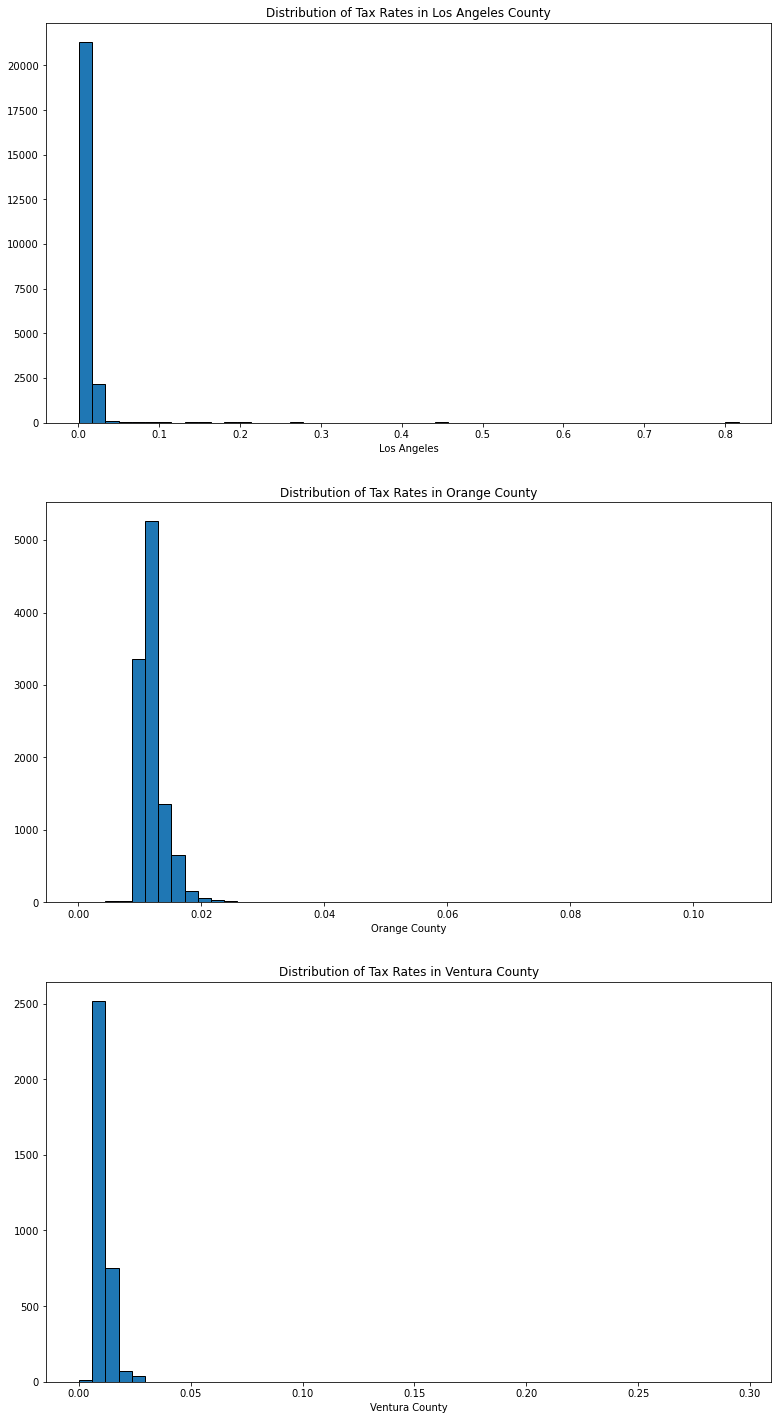

In [45]:
plt.figure(figsize=(13,25))
plt.subplot(3,1,1, xlabel = 'Los Angeles', title='Distribution of Tax Rates in Los Angeles County')
plt.hist(data=new_tax[new_tax.fips == 6037],bins=50, x='tax_rate',ec='black')

plt.subplot(3,1,2, xlabel = 'Orange County',title='Distribution of Tax Rates in Orange County')
plt.hist(data=new_tax[new_tax.fips == 6059],bins=50, x='tax_rate', ec='black')

plt.subplot(3,1,3, xlabel = 'Ventura County', title='Distribution of Tax Rates in Ventura County')
plt.hist(data=new_tax[new_tax.fips == 6111],bins=50, x='tax_rate',ec='black')

plt.show()

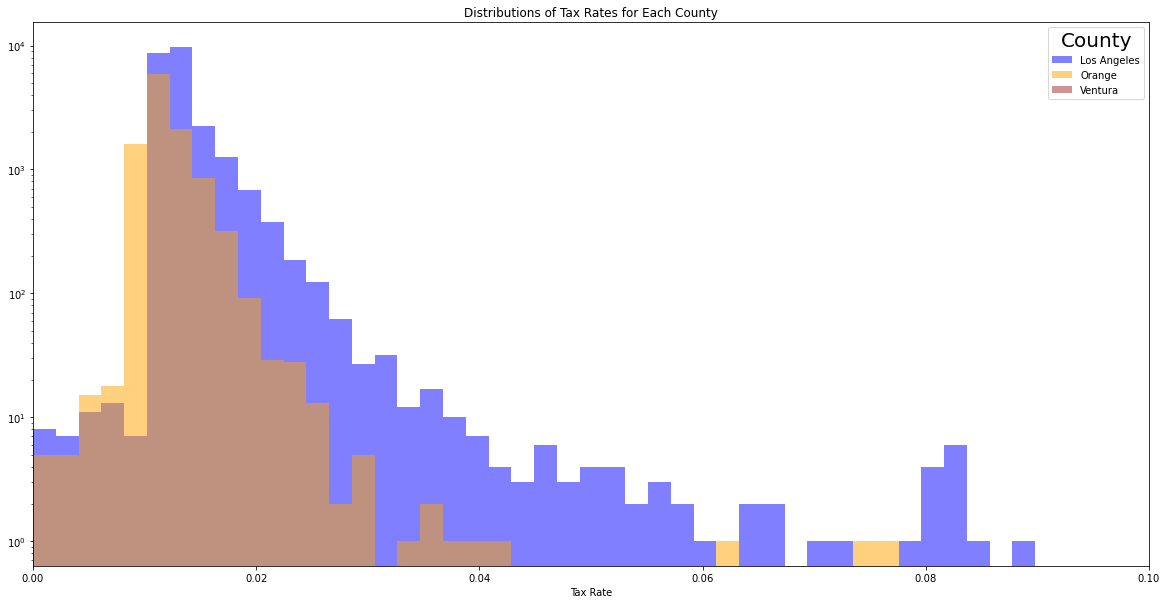

In [48]:
#all the tax distributions on one graph
plt.figure(figsize=(20,10))
    # start plot
plt.hist(new_tax[new_tax.county == 'Los Angeles'].tax_rate, bins=np.linspace(0, 0.1, 50), color='blue', alpha=0.50, log=True, label='Los Angeles')
plt.hist(new_tax[new_tax.county == 'Orange'].tax_rate, bins=np.linspace(0, 0.1, 50), color='orange', alpha=0.50, log=True, label='Orange')
plt.hist(new_tax[new_tax.county == 'Venture'].tax_rate, bins=np.linspace(0, 0.1, 50), color='brown', alpha=0.50, log=True, label='Ventura')
plt.rcParams['legend.title_fontsize'] = 20
plt.xlim(0, 0.1)
plt.xlabel('Tax Rate')
plt.title('Distributions of Tax Rates for Each County')
plt.legend(title='County')
plt.show()
    

In [52]:
#here are the tax rates in percentages for each county
county_mean_tax_rate

,tax_rate_percent
county,
Los Angeles,1.38
Orange,1.20
Ventura,1.19


Takeaways:
 - Most properties in our set was from Los Angeles, and they seem to have higher tax rates than Orange or Ventura county. 
 - Los Angeles County, even after dropping outliers, is skewed to the right on tax rates.
 - Orange and Ventura county seem to have very close tax rates, but seems to be more diversity in Orange. 

In [46]:
#let's turn this into a .csv
new_tax

,sqft,baths,beds,tax_value,fips,tax_amount,age,tax_rate,county
parcel_id,,,,,,,,,
14634203,1125.0,2.0,3.0,289445.0,6059.0,3490.16,43.0,0.012058,Orange
11721753,1316.0,2.0,3.0,205123.0,6037.0,2627.48,94.0,0.012809,Los Angeles
11289917,1458.0,2.0,3.0,136104.0,6037.0,2319.90,47.0,0.017045,Los Angeles
11637029,1766.0,2.0,3.0,810694.0,6037.0,9407.01,37.0,0.011604,Los Angeles
11705026,1421.0,1.0,2.0,35606.0,6037.0,543.69,106.0,0.015270,Los Angeles
...,...,...,...,...,...,...,...,...,...
14453399,3015.0,3.0,5.0,852813.0,6059.0,11662.88,15.0,0.013676,Orange
12019061,769.0,2.0,1.0,492395.0,6037.0,6023.37,53.0,0.012233,Los Angeles
11570288,1212.0,2.0,2.0,600608.0,6037.0,7255.87,48.0,0.012081,Los Angeles


In [ ]:
new_tax

In [47]:
new_tax.to_csv('county_tax.csv')

In [51]:
#and this little dataframe too just in case we want to see it later
county_mean_tax_rate.to_csv('tax_rates')

<br>

## Conclusions, Next Steps...

To conclude...
We took a very large Zillow dataset and condensed it down to 37,927 rows to work with. We dropped rows with outliers of 3 standard deviations above or below the mean for that column. 

1.) Square footage was the best feature to determine a property's value. As square footage increased, it seemed that value also went up.

2.) The more bedrooms and bathrooms a house has, the more it was worth. These number of rooms also related to square footage in a positive relationship.

3.) Age was not a huge factor in value, but was helpful in our model's predictions.

4.) Using all of square footage, number of bedrooms, number of bathrooms, and age into a model performed better than the baseline. 

5.) All three counties have similar tax rates, but LA has the highest.

<br>

With more time, I would definitely look into the other columns and see if they could contribute positively to our prediction model with some cleaning up on nulls and outliers. I believe location is still a huge factor on value, so I'd try to work with columns like latitude/longitude, zip code, etc. as FIPS was not a great indicator for value on how general it is.